In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import get_average_digit_instance_name

from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


## Load input data

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


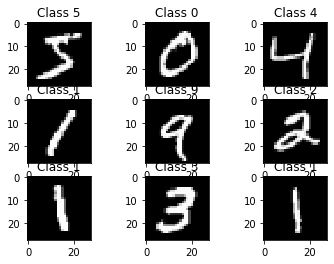

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Prepare data

In [4]:
#prepare correct data shape for Activation Maximization compatibility
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [5]:
all_data = np.append(X_test, X_train, axis=0)
all_onehot_labels = np.append(Y_test, Y_train, axis=0)
all_labels = np.append(y_test, y_train, axis=0)
print(all_data.shape)
print(all_onehot_labels.shape)
print(all_labels.shape)

(70000, 28, 28, 1)
(70000, 10)
(70000,)


## Create neural network

In [6]:
l1_neurons, l2_neurons = 64, 64

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape, name='conv1'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())  # Activation Maximization needs the model to take in structured images, but our NN is fully connected
model.add(Dense(l1_neurons, activation='relu', name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(l2_neurons, activation='relu', name='fc2'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='predictions'))

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train network

In [8]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4, verbose=1,
          validation_data=(X_test, Y_test))

C:\Users\prokopcerny\.conda\envs\VIZ\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 5s 81us/step - loss: 0.3665 - accuracy: 0.8852 - val_loss: 0.0665 - val_accuracy: 0.9783

### Save model

In [10]:
model.save("./trained_model")

### Load model

In [7]:
model = load_model("./trained_model")


In [8]:
model.predict(X_test[0:1])

array([[2.5413069e-10, 7.2725108e-08, 1.8006385e-07, 8.1381025e-08,
        8.0439619e-09, 1.0159780e-11, 2.0304480e-13, 9.9999964e-01,
        1.1882655e-11, 5.4441585e-08]], dtype=float32)

In [9]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.037679560108653094
Test accuracy: 0.9879999756813049


In [60]:
# Create selections of a subset of images for each digits and append all missclasifications
digit_to_name = {0: "Zero",
                 1: "One",
                 2: "Two",
                 3: "Three",
                 4: "Four",
                 5: "Five",
                 6: "Six",
                 7: "Seven",
                 8: "Eight",
                 9: "Nine"}

def get_instance_name(digit, num):
    return f'{digit_to_name[digit]} #{num}'

np.random.seed(123)
random_sample_size = 200
digit_selected_data = {}
instance_prediction_results = {get_average_digit_instance_name(digit): {'real': digit, 'pred': digit} for digit in range(10)}

for digit in range(10):
    cur_digit_data = all_data[all_labels == digit]
    # cur_digit_labels = all_labels[all_labels == digit]

    predicted = model.predict_classes(cur_digit_data)

    incorrect_indices = np.nonzero(predicted != digit)[0]
    selected_indices = np.random.choice(cur_digit_data.shape[0], size=(random_sample_size,), replace=False)
    incorrect_unselected = np.fromiter(set(incorrect_indices)-set(selected_indices), dtype=incorrect_indices.dtype)
    all_selected_indices = np.append(selected_indices, incorrect_unselected)
    all_subset = cur_digit_data[all_selected_indices]
    all_subset_preds = predicted[all_selected_indices]
    dimred_mask = np.zeros_like(all_selected_indices, dtype=bool)
    dimred_mask[:random_sample_size] = True
    names = []
    for num, predicted_class in enumerate(all_subset_preds, start=1):
        cur_name = get_instance_name(digit, num)
        names.append(cur_name)
        instance_prediction_results[cur_name] = {'real': digit, 'pred': int(predicted_class)}
    npnames = np.array(names)
    digit_selected_data[digit] = (all_subset, all_subset_preds, npnames, dimred_mask)

    print(f'{incorrect_indices.shape}'
          f' {selected_indices.shape}'
          f' {incorrect_unselected.shape}'
          f' {all_selected_indices.shape}'
          f' {dimred_mask[0]} {dimred_mask[199]} {dimred_mask[200]} {dimred_mask[-1]}'
          f' {np.nonzero(all_subset_preds != digit)[0].shape}')


# np.nonzero(model.predict_classes(all_data) != all_labels)[0].shape

(13,) (200,) (12,) (212,) True True False False (13,)
(28,) (200,) (28,) (228,) True True False False (28,)
(86,) (200,) (81,) (281,) True True False False (86,)
(78,) (200,) (77,) (277,) True True False False (78,)
(39,) (200,) (39,) (239,) True True False False (39,)
(38,) (200,) (36,) (236,) True True False False (38,)
(46,) (200,) (45,) (245,) True True False False (46,)
(24,) (200,) (24,) (224,) True True False False (24,)
(78,) (200,) (73,) (273,) True True False False (78,)
(89,) (200,) (86,) (286,) True True False False (89,)


### Create intermediate layer activations

In [61]:
# fc1_output = Model(inputs=model.input, outputs=model.get_layer(name='fc1').output)
# fc2_output = Model(inputs=model.input, outputs=model.get_layer(name='fc2').output)
# print(fc1_output.predict(X_test[0:1]))
intermediate_outputs = Model(inputs=model.input, outputs=[model.get_layer(name='fc1').output,
                                                          model.get_layer(name='fc2').output,
                                                          model.output])
fc1_t, fc2_t, out_t = map(lambda x: np.average(x, axis=0), intermediate_outputs.predict(X_test[0:2]))


In [62]:
# create average activations for each digit
fc1_activations = {}
fc2_activations = {}
output_activations = {}
for digit in range(10):
    cur_name = get_average_digit_instance_name(digit)
    print(f'\r{cur_name}', end="")
    cur_digit = all_data[all_labels == digit]
    fc1_t, fc2_t, out_t = map(lambda x: np.average(x, axis=0).tolist(), intermediate_outputs.predict(cur_digit))
    fc1_activations[cur_name], fc2_activations[cur_name], output_activations[cur_name] = fc1_t, fc2_t, out_t
print("\nDone")
# print(np.average(fc1_output.predict(all_data[all_labels == 0]), axis=0).shape)

Average 9
Done


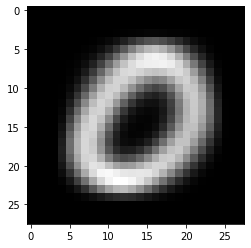

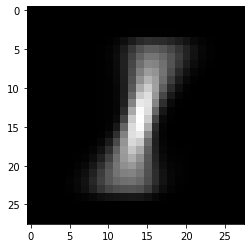

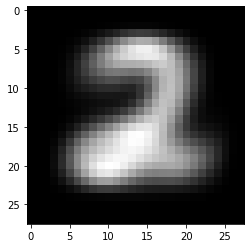

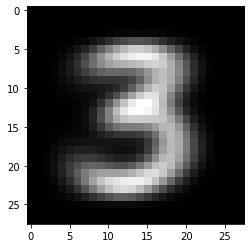

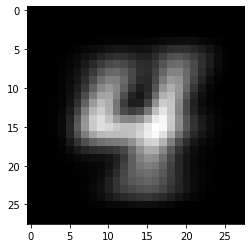

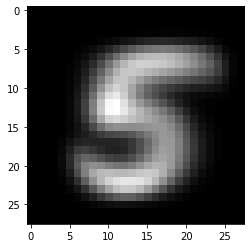

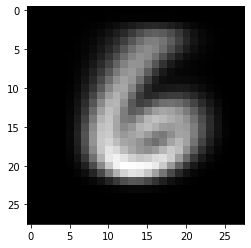

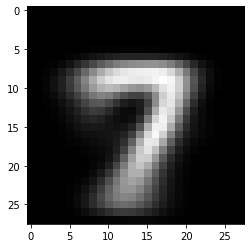

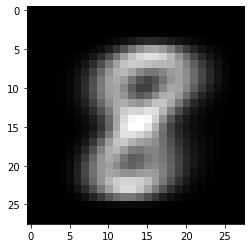

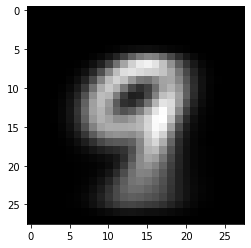

In [63]:
# create images of average digits
images = {}
for digit in range(10):
    cur_name = get_average_digit_instance_name(digit)
    cur_digit = np.average(all_data[all_labels == digit], axis=0).reshape(28,28)
    images[cur_name] = cur_digit.tolist()
    plt.figure()
    plt.imshow(cur_digit, cmap='gray', interpolation='none')

In [64]:
digit_to_instances = {digit:[get_average_digit_instance_name(digit)] for digit in range(10)}

In [65]:
for digit, (cur_images, cur_labels, cur_names, cur_dimred_mask) in digit_selected_data.items():
    fc1_t, fc2_t, out_t = intermediate_outputs.predict(cur_images)
    for instance_name, fc1a, fc2a, oa, img in zip(cur_names, fc1_t, fc2_t, out_t, cur_images.reshape(-1, 28, 28)):
        print(f'\r{instance_name}'+10*' ', end="")
        fc1_activations[instance_name] = fc1a.tolist()
        fc2_activations[instance_name] = fc2a.tolist()
        output_activations[instance_name] = oa.tolist()
        images[instance_name] = img.tolist()
        digit_to_instances[digit].append(instance_name)
print('\nDone')

Nine #286           
Done


In [ ]:
# images_to_use = 49
# for digit in range(10):
#     cur_digit = all_data[all_labels == digit][:images_to_use]
#     fc1_t, fc2_t, out_t = intermediate_outputs.predict(cur_digit)
#     for idx, fc1a, fc2a, oa, img in zip(range(images_to_use),fc1_t, fc2_t, out_t, cur_digit.reshape(-1, 28, 28)):
#         #instance_name = f'{digit_to_name[digit]} #{idx+1}'
#         instance_name = get_instance_name(digit, idx+1)
#         print(f'\r{instance_name}'+10*' ', end="")
#         fc1_activations[instance_name] = fc1a.tolist()
#         fc2_activations[instance_name] = fc2a.tolist()
#         output_activations[instance_name] = oa.tolist()
#         images[instance_name] = img.tolist()
#         digit_to_instances[digit].append(instance_name)
# print('\nDone')



## Create JSON
As a python dictionary is more or less analogous to JSON objects,
 the schema can be seen by inspecting out_data dictionary

In [66]:
activations = {'FC1': fc1_activations,
               'FC2': fc2_activations,
               'Output': output_activations}

In [67]:
len(instance_prediction_results)

2511

In [68]:
out_data = {'activations': activations,
            'images': images,
            'digit_to_instances': digit_to_instances,
            'prediction_results': instance_prediction_results}

In [69]:
#prototype for saving data
# saves the first fully connected layer activations to a file
import json
from pathlib import Path
with Path('./NN_data.json').open(mode='w', newline='\n') as file:
    file.write(json.dumps(out_data))
    file.write('\n')

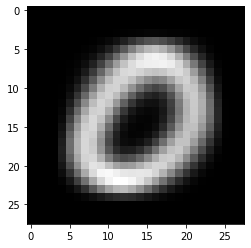

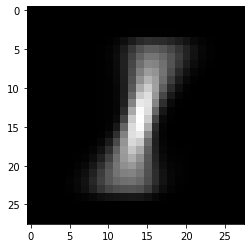

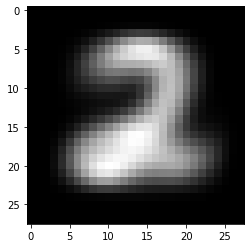

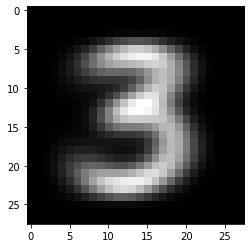

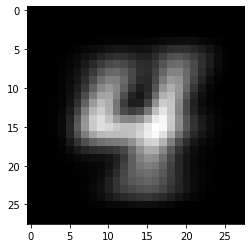

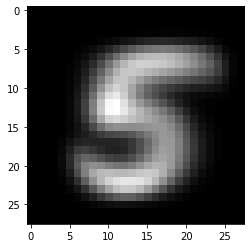

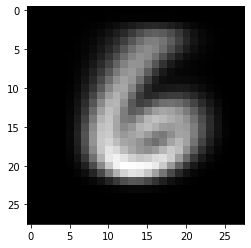

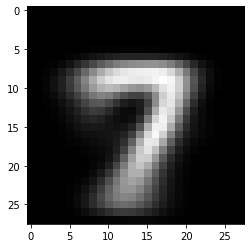

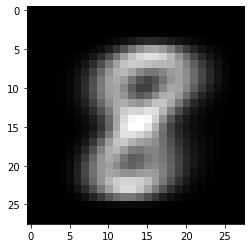

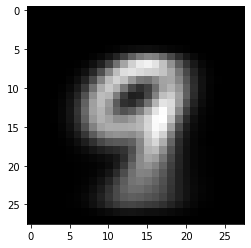

In [29]:
for digit in range(10):
    plt.figure()
    plt.imshow(np.average(all_data[all_labels == digit], axis=0).reshape(28,28), cmap='gray', interpolation='none')

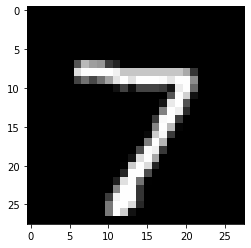

In [15]:
plt.imshow(X_test[0].reshape(28,28), cmap='gray', interpolation='none')

In [16]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

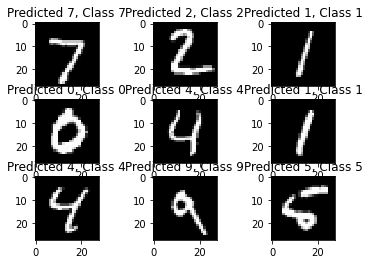

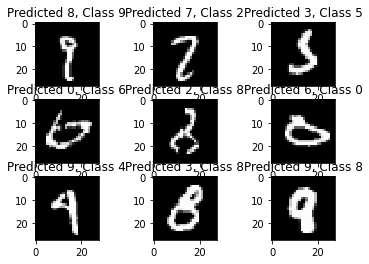

In [17]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [18]:
#ActMax
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## Visualize max activations for all digits

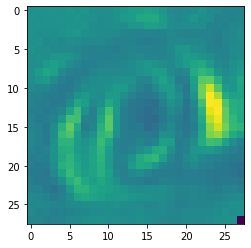

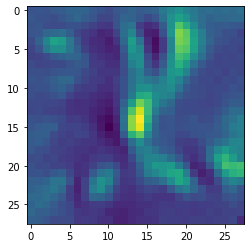

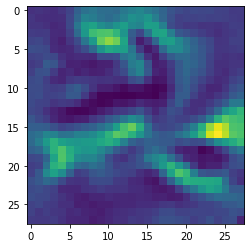

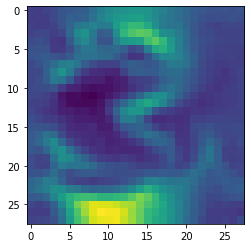

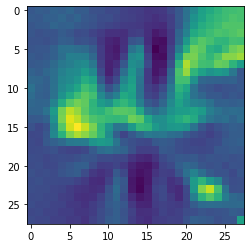

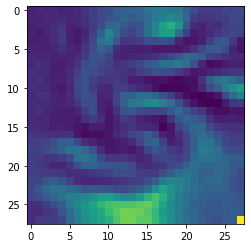

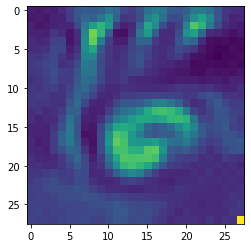

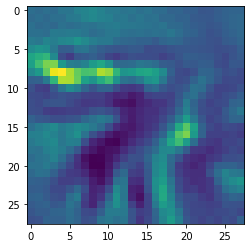

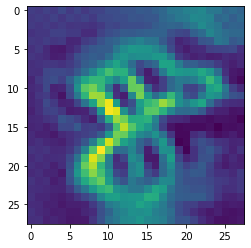

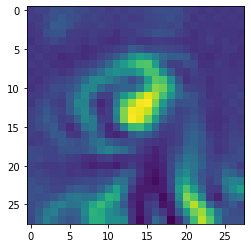

In [19]:
for digit in range(10):
    img = visualize_activation(model, layer_idx, filter_indices=digit, input_range=(0., 1.))
    plt.figure()
    plt.imshow(img[..., 0])

## Visualize activation combining multiple digits

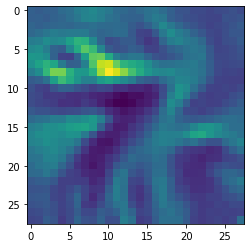

In [20]:
digit_mix = [1,7] # we want to see what the network things is both 1 and 7
img = visualize_activation(model, layer_idx, filter_indices=digit_mix, input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

